In [1]:
#matplotlib
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

#numpy
import numpy as np

#fit
from scipy.optimize import curve_fit
from scipy.stats import norm, cauchy

#center graphs
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

# Exercise 1

## 1.1

Test the Pseudo-Random Number generator downloaded from the NSL Ariel web site by estimating:
1. $\langle r \rangle = \int_0^1 r dr = 1/2$. Make a picture of the estimation of $\langle r \rangle$ and its uncertainty (which corresponds to Standard Deviation of the mean for the estimation of $\langle r \rangle$) with a large number of *throws* $M$ (e.g. $M\ge 10^4$) as a function of the number of blocks, $N$ (see below: Computing statistical uncertainties).
2. $\sigma^2 = \int_0^1 (r-1/2)^2 dr = 1/12$. Make a picture of the estimation of $ \sigma^2$ and its uncertainty (which corresponds to Standard Deviation of the mean for the estimation of $\langle (r-1/2)^2 \rangle$) with a large number of *throws* $M$ (e.g. $M\ge 10^4$) as a function of the number of blocks, $N$ (see below: Computing statistical uncertainties).
3. Divide $[0,1]$ into $M$ identical sub-intervals and implement the $\chi^2$ test. Obviously, the number of expected events observed in each sub-interval after $n$ *throws*, according to a uniform distribution, is $np = n\times 1/M= n/M$. Fix $M=10^2$ and use for $n$ the first $10^4$ pseudo-random numbers, then the successive $10^4$ pseudo-random numbers, and so on ... 100 times. Plot $\chi^2_j$ for $j=1, ..., 100$. In this case the chi-square statistic is:
$$\chi^2 = \sum_{i=1}^M \frac{\left( n_i - n/M \right)^2}{n/M}$$
We should expect on average that $(n_i - n/M)^2 \simeq n/M$ and thus $\chi^2 \simeq 100$, i.e. the number of sub-intervals. A larger value of $\chi^2$ indicates that the hypothesis ($n_i$ are drawn from a uniform distribution) is rather unlikely ... but before judging, you could compare the histogram of the values obtained for $\chi^2_j$ with the true probability distribution (see: <a href="https://en.wikipedia.org/wiki/Chi-squared_distribution">this Wikipedia link</a>).

## Solution


The Random generator we were given supposedly generates number uniformly distributed in the range $\left[0,1\right]$. Since we will be using this generator and its other functions which allow us to sample different distributions, we want to verify how it performs by evaluating the average value of the generated numbers and its uncertainty; the variance and finally test the $\chi^2$

The resolution of this first part of the exercise 1 is cointained in the directory `./1.1` and all 3 points of the exercise are coded for in the file `main.cpp`. The code produces its output files as `1.1.*.dat`.

### Estimation of average value of $r$

Inside the section in `main.cpp` dedicated to exercise 1.1.1, two `for` loops are utilized to draw a random number using the function `rnd.Rannyu()` which in the following equations will be called $r_i$. To operate with blocking average, the total number of throws, `iterations` in the code, was set to $M=10^6$ and divided into $N=100$ `blocks` making for a `blockSize` of $L=10^4$. Within each block the average was calculated, and then the progressive average, i.e. the average of the average of all previous blocks, was saved to file. For the k-th block, the error was set to the standard deviation of the mean $\sigma_k$
$$ \sigma_k = \sqrt{\frac{1}{k-1} \left[ \frac{1}{k} \sum_{i=1}^k \left( \frac1N \sum_{j=0}^N r_j\right)^2 - \left( \frac{1}{k} \sum_{i=1}^k \left( \frac1N \sum_{j=0}^N r_j\right) \right)^2 \right]} ,$$
where
$$ \left\langle r \right\rangle = \left( \frac1N \sum_{j=0}^N r_j\right) \quad \quad \left\langle r^2 \right\rangle = \left( \frac1N \sum_{j=0}^N r_j\right)^2 $$
Thus we have
$$ \sigma_k = \sqrt{\frac{1}{k-1} \left[ \frac{1}{k} \sum_{i=1}^k \left\langle r^2 \right\rangle - \left( \frac{1}{k} \sum_{i=1}^k \left\langle r \right\rangle \right)^2 \right]}$$
These formulas are evidently not usable for the first block, where $k-1=0$ which has a statistical meaning too: it is not reasonable to ask the average among blocks and the uncertainty when there has been only one block drawn so far. Here the error is set to $0$.

The graphs below show the progressive average $\left(\left\langle r \right\rangle -0.5\right)$ and the error bars with the associated progressive error. Also plotted is the trend of the error in function of the blocks.

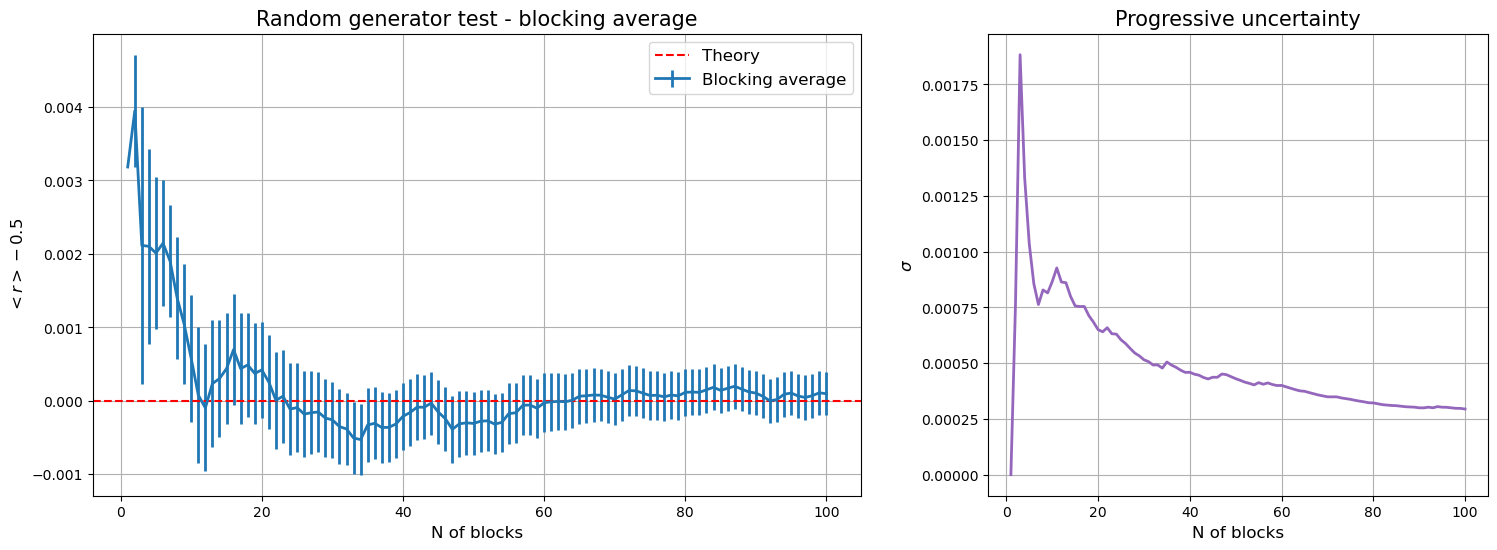

In [2]:
# Load data from file '1.1/1.1.1.dat', using columns 0 and 1
x_label, progressive_average, progressive_error = np.loadtxt('1.1/1.1.1.dat', unpack = True, usecols=(0, 1, 2))

# Create a figure with 2 subplots, using width ratios of [2, 1.3] for the subplots
fig, axs = plt.subplots(ncols=2, gridspec_kw={'width_ratios': [2, 1.3]}, figsize=(18,6))

# Plot data in the first subplot
axs[0].errorbar(x_label, progressive_average-0.5, yerr=progressive_error,lw=2, label='Blocking average', c='tab:blue')
axs[0].grid(True)  # Add grid lines to the plot
axs[0].axhline(0, ls='--', c='red', label='Theory')  # Add a horizontal line at y=0 in red
axs[0].set_xlabel('N of blocks', fontsize=12)
axs[0].set_ylabel('$<r>-0.5$', fontsize=12)
axs[0].legend(fontsize=12)  # Add a legend to the plot
axs[0].set_title('Random generator test - blocking average', fontsize=15)

# Plot data in the second subplot
axs[1].plot(x_label, progressive_error,lw=2, c='tab:purple')
axs[1].grid(True)  # Add grid lines to the plot
axs[1].set_xlabel('N of blocks', fontsize=12)
axs[1].set_ylabel('$\sigma$', fontsize=12)
axs[1].set_title('Progressive uncertainty', fontsize=15)

# Show the plot
plt.show()

### Estimation of the variance

Similarly to the process explained for the estimation of $\left\langle r \right\rangle$, we now set out to estimate the variance of the Random number generator. We use the two `for` loops as said above for the block averaging, with the sole difference that now our generated value, for each time we iterate inside the loops, is 
````cpp
rand = pow(rnd.Rannyu() - 0.5, 2)
`````
thus with block averaging we will then be estimating $\left\langle \left( r - 0.5 \right)^2 \right\rangle$. 

The same values for `iterations`, `blocks` and `blockSize` were used as above. 

The graphs below show the progressive average of the variance and the error bars with the associated progressive error. The variance will be compared to the expected value of $\sigma^2=1/12$. Also plotted is the trend of the error in function of the blocks.

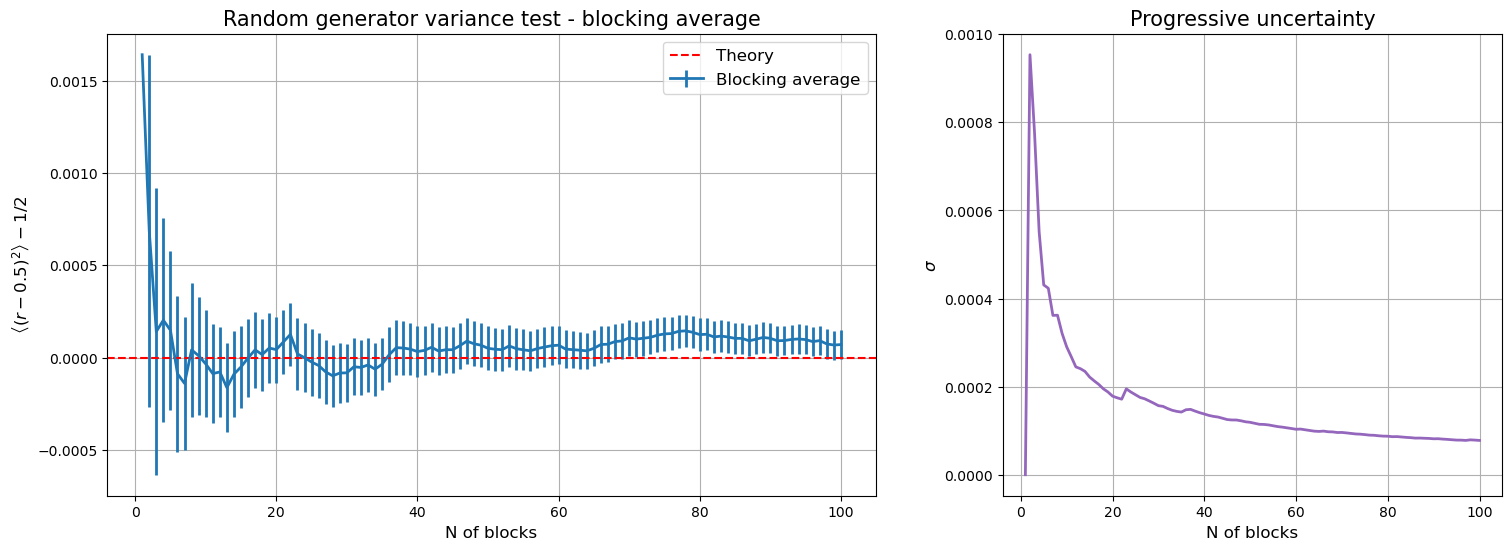

In [3]:
# Load data from file '1.1/1.1.2.dat', using columns 0 and 1
x_label, progressive_average, progressive_error = np.loadtxt('1.1/1.1.2.dat', unpack = True, usecols=(0, 1, 2))

# Create a figure with 2 subplots, using width ratios of [2, 1.3] for the subplots
fig, axs = plt.subplots(ncols=2, gridspec_kw={'width_ratios': [2, 1.3]}, figsize=(18,6))

# Plot data in the first subplot
axs[0].errorbar(x_label, progressive_average-1/12, yerr=progressive_error,lw=2, label='Blocking average', c='tab:blue')
axs[0].grid(True)  # Add grid lines to the plot
axs[0].axhline(0, ls='--', c='red', label='Theory')  # Add a horizontal line at y=0 in red
axs[0].set_xlabel('N of blocks', fontsize=12)
axs[0].set_ylabel(r'$\left\langle \left( r - 0.5 \right)^2 \right\rangle - 1/2$', fontsize=12)
axs[0].legend(fontsize=12)  # Add a legend to the plot
axs[0].set_title('Random generator variance test - blocking average', fontsize=15)

# Plot data in the second subplot
axs[1].plot(x_label, progressive_error,lw=2, c='tab:purple')
axs[1].grid(True)  # Add grid lines to the plot
axs[1].set_xlabel('N of blocks', fontsize=12)
axs[1].set_ylabel('$\sigma$', fontsize=12)
axs[1].set_title('Progressive uncertainty', fontsize=15)

# Show the plot
plt.show()

### Estimation of $\chi^2$

Our final test of the Random number generator is the $\chi^2$ test. In order to achieve this, we divided the interval $\left[0,1\right]$ into `intervals = 100` sub-intervals, inside each of which, the following piece of code was repeated for `iterations = 10^4` times. Each iterations draws a number randomly, and the with the `std::floor()` function, a `std::vector<int> n_i (intervals)`, i.e. a vector of ints the size of the intervals, keeps count of the number of draws that fall into each sub-interval.
````cpp
rand_chi = rnd.Rannyu();
n_i[floor( (double) intervals * rand_chi)]++;
`````
Then the following formula is used to evaluate the $\chi^2$ 
$$\chi^2 = \sum_{i=1}^M \frac{\left( n_i - n/M \right)^2}{n/M}$$
where $n/M$ is the expected value of the count of draws for each sub-interval, i.e. `step = iterations/intervals = 100`, thus the closest $n_i$ is to $100$, the higher the $\chi^2$ it will be.

The following scatter plot shows the $\chi^2$ of each run test, for a total of `tests = 100`, the mean value found and the expected value of $\chi^2=100$.

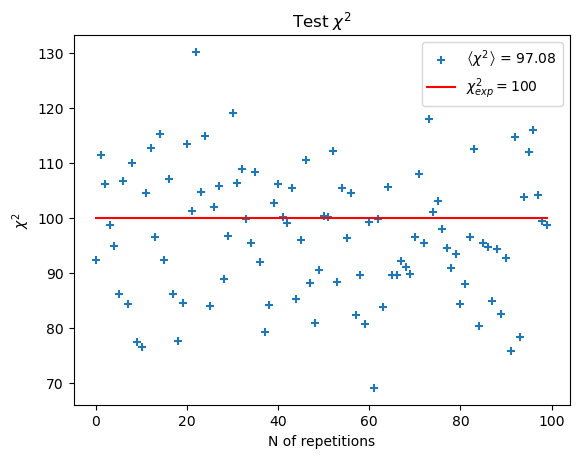

In [4]:
# chi2 test
from scipy.stats import chi2

# Data acquisition
x_label, chi2 = np.loadtxt("./1.1/1.1.3.dat", unpack=True)

# Calculate the mean value of chi2
mean_chi2 = np.mean(chi2)

# Plot
plt.scatter(x_label, chi2, marker='+')
g = np.full(x_label.size, 100)
plt.plot(x_label, g, c='red', label='Expected')

# Title and axis labels
plt.title('Test $\chi^2$')
plt.xlabel('N of repetitions')
plt.ylabel('$\chi^2$')

# Add the mean value to the legend
plt.legend([r'$\left\langle\chi^2\right\rangle$ = {:.2f}'.format(mean_chi2), '$\chi^2_{exp} = 100$'])

plt.show()

### Extra $\chi^2$ test

The distribution we got of the values of $\chi^2$ gave an average very close to the expected value of $\chi^2_{exp}=100$. However, to further verify that the oscilattions that we see in the above scatter, ranging from $70$ to $140$, are actually coherent with the $\chi^2$ probability density function (PDF), we drew many more tests, now setting `tests = 3000`. Below are drawn the scatter of all tests, together with an histogram were we used as fitting function the `chi2.pdf` function imported from the `scipy.stats` library. Results are very positive.

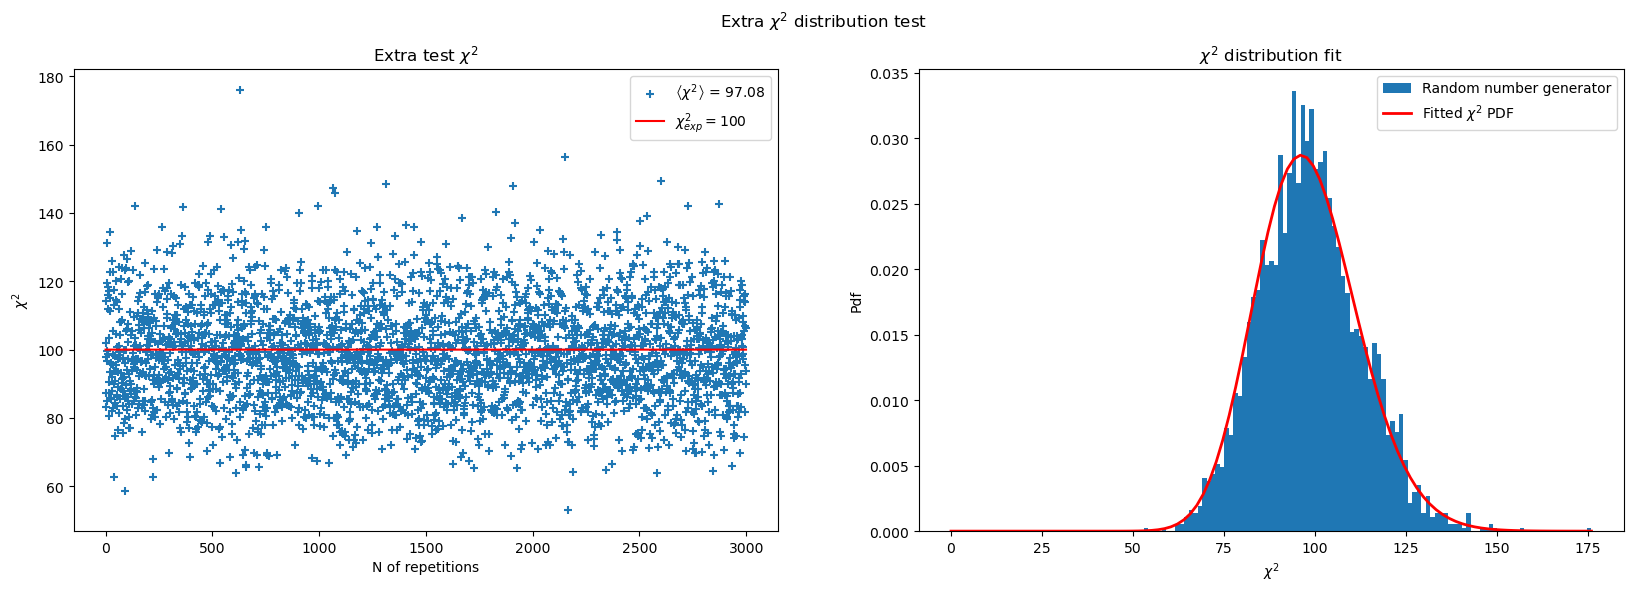

In [5]:
# Data acquisition extra chi^2 test
x_label, chi2_data = np.loadtxt("./1.1/1.1.3_extra.dat", unpack = True, usecols = (0,1))

from scipy.stats import chi2

# define subplots
fig, axs = plt.subplots(ncols=2, gridspec_kw={'width_ratios': [1,1]}, figsize=(20,6))
fig.suptitle(r"Extra $\chi^2$ distribution test")

# number of bins
n_bins = 100

# Plot first subplot
axs[0].scatter(x_label, chi2_data, marker='+')
g = np.full(x_label.size, 100)
axs[0].plot(x_label, g, c='red', label='Expected')

# Title and axis labels first subplot
axs[0].set_title('Extra test $\chi^2$')
axs[0].set_xlabel('N of repetitions')
axs[0].set_ylabel('$\chi^2$')

# Add the mean value to the legend first subplot
axs[0].legend([r'$\left\langle\chi^2\right\rangle$ = {:.2f}'.format(mean_chi2), '$\chi^2_{exp} = 100$'])

hist, bins = np.histogram(chi2_data, bins=n_bins, density=True)


# Fit the chi-squared distribution to the histogram
popt, pcov = curve_fit(chi2.pdf, bins[:-1], hist, p0=99)

# Generate x values for plotting the PDF
x = np.linspace(0, np.max(bins), 100)

# Plot the histogram and fitted PDF
axs[1].hist(chi2_data, bins=bins, density=True, label= 'Random number generator')
axs[1].plot(x, chi2.pdf(x, *popt), 'r-', lw=2, label='Fitted $\chi^2$ PDF')
axs[1].set_xlabel('$\chi^2$')
axs[1].set_ylabel('Pdf')
axs[1].set_title('$\chi^2$ distribution fit')
axs[1].legend()

plt.show()

In [6]:
import scipy.stats as stats
p_value = 1 - stats.chi2.cdf(np.mean(chi2_data), 99)
print(r'Probability : ', p_value)

Probability :  0.4885862505812595


As a final check, the $\chi^2$ statistics allow us to extrapolate the p_value, which gives the likelihood of observing the resulted $\chi^2$ with discrepancy due only to chance. Usually a probability less than $5\%$ would mean that the distribution is not likely to be observed as is due only to chance. The result we got, however, with probability of around $48\%$ shows that the hypothesis that the distribution is uniform indeed holds.

## 1.2

Extend Pseudo-Random Number generator downloaded from the NSL Ariel web site and check the Central Limit Theorem:
1. Add two probability distributions by using the **method of the inversion of the cumulative distribution** to sample from a **generic** exponential distribution, $p(x) = \lambda \exp(-\lambda x)$, $x\in [0;+\infty]$ (see <a href="https://en.wikipedia.org/wiki/standard_distribution">this Wikipedia link</a>), and a **generic** Cauchy-Lorentz distribution $p(x)=\frac{1}{\pi}\frac{\Gamma}{(x-\mu)^2+\Gamma^2}$, $x\in [-\infty;+\infty]$ (see <a href="https://en.wikipedia.org/wiki/Cauchy_distribution">this Wikipedia link</a>).
2. Make 3 pictures</font> with the histograms obtained filling them with $10^4$ realizations of $S_N = \frac{1}{N}\sum_{i=1}^N x_i$ (for $N=1, 2, 10, 100$), being $x_i$ a random variable sampled throwing a *standard* dice (fig.1), an *standard* dice (fig.2, use $\lambda=1$) and a *Lorentzian* dice (fig.3, use $\mu=0$ and $\Gamma=1$).

Note tha you can try to fit the case $N=100$ with a Gaussian for standard and exponential dices, whereas you should use a Cauchy-Lorentz distribution for the last case.

## Solution

In this exercise we are going to extend the Random Number Generator to more distributions, and use this to verify the Central Limit Theorem (CLT). In short, the CLT states that, under appropriate conditions, the distribution of a normalized version of the sample mean converges to a standard normal distribution. The distributions have to be with finite mean and variance, and the result holds even if the original variables themselves are not normally distributed. In our case we will be testing this with a uniform distribution and an exponential distribution. Finally we will show how the Cauchy-Lorentz distribution is in itself stable, and will not converge to a Gaussian distribution, but rather will remain a Cauchy-Lorentz even after having combined numerous iterations of the distribution.

To show this convergence we draw numbers for each distribution and take the average $S_N = \frac{1}{N}\sum_{i=1}^N x_i$ were $N$ is the numbers drawn. We save values for $N=1, 2, 10, 100$, to appreciate the progressive convergenve of the distributions. For each value of $N$ the process is iterated over `iterations = 10^5`.

All three distributions are generated from the file `main.cpp` contained in the directory `./1.2`. We will show later how each the exponential and cauchy-lorentz distributions were sampled.

### Uniform distribution

Now pretty simply to sample a uniform distribution, we take the already well known `rand.Rannyu()` method of the Random Gen class to draw a number uniformly in $\left[0,1\right]$. Below are shown histograms for $10^5$ iterations of the average $S_N = \frac{1}{N}\sum_{i=1}^N x_i$ for $N=1, 2, 10, 100$

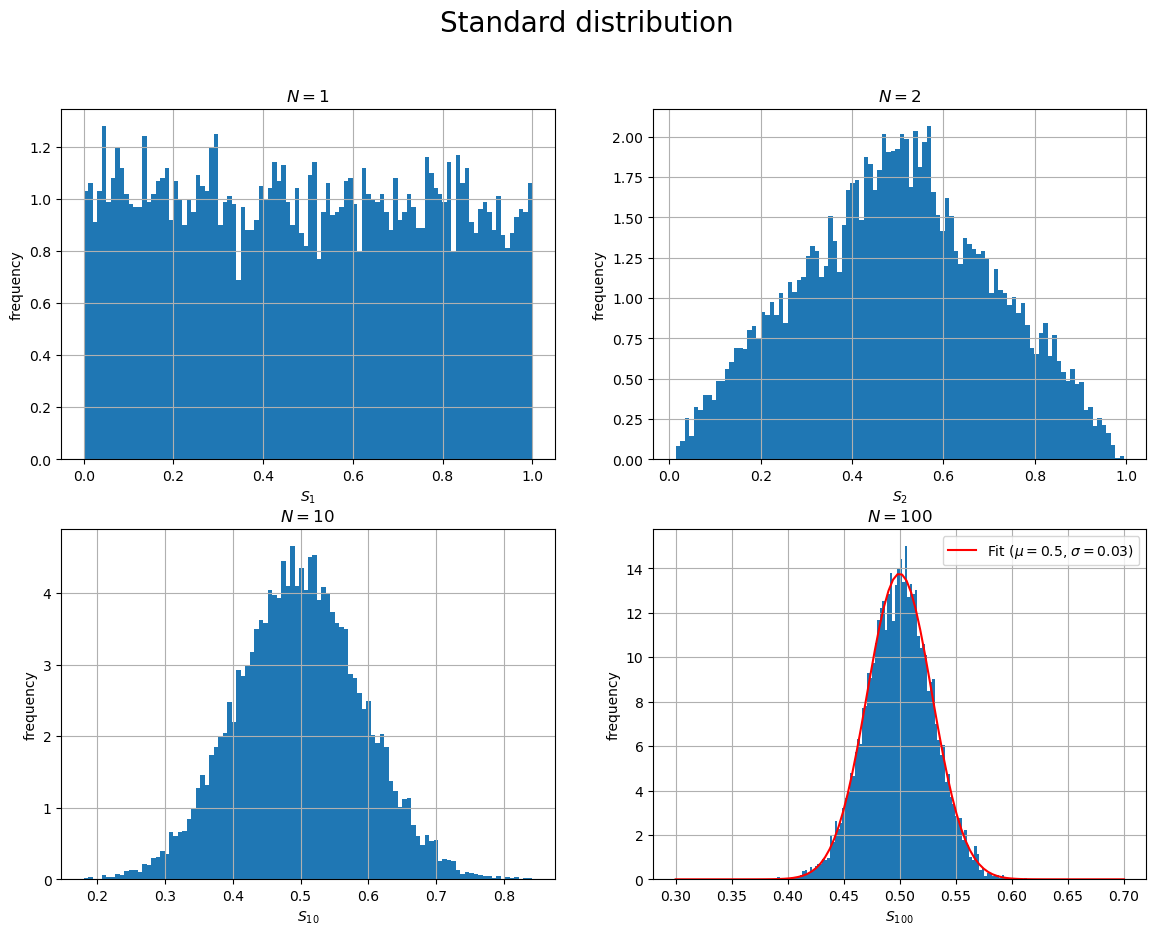

In [7]:
# Standard distribution

# defining the fitting function
def gauss(x, mu, sigma):
    return norm.pdf(x, mu, sigma)

# Data acquisition
S_n1, S_n2, S_n3, S_n4= np.loadtxt("./1.2/1.2_standard.dat", unpack = True, usecols=(1,2,3,4))

#define variables
n_bins = 100

#style
fig=plt.figure(figsize = (14,10))
fig.suptitle('Standard distribution', fontsize=20)

#plot
plt.subplot(2,2,1)
n, bins, patches = plt.hist(S_n1, n_bins, density = True)
plt.grid()
plt.ylabel("frequency")
plt.title("$N=1$")
plt.xlabel("$S_1$")

plt.subplot(2,2,2)
n, bins, patches = plt.hist(S_n2, n_bins, density = True)
plt.grid()
plt.ylabel("frequency")
plt.title("$N=2$")
plt.xlabel("$S_2$")

plt.subplot(2,2,3)
n, bins, patches = plt.hist(S_n3, n_bins, density = True)
plt.grid()
plt.ylabel("frequency")
plt.xlabel("$S_{10}$")
plt.title("$N=10$")

plt.subplot(2,2,4)
n, bins, patches = plt.hist(S_n4, n_bins, density = True)
plt.grid()
plt.ylabel("frequency")
plt.xlabel("$S_{100}$")
plt.title("$N=100$")

#fit
bins = np.linspace(0.3, 0.7, 10001)
data_entries, bins = np.histogram(S_n4, bins = bins, density = True)
binscenters = np.array([0.5 * (bins[i] + bins[i + 1]) for i in range(len(bins)-1)])
popt, pcov = curve_fit(gauss, xdata = binscenters, ydata = data_entries)
xspace = np.linspace(0.3, 0.7, 100)
y_fit = gauss(xspace, popt[0], popt[1])

#plot fit
lab ='Fit ($\mu=$' + str(round(popt[0], 2)) + ', $\sigma=$' + str(round(popt[1], 2)) + ')'
plt.plot(xspace, y_fit, color = 'red', label = lab)
plt.legend()

plt.show()

To show the convergence of the distribution to a Gaussian, we fitted the last histogram, $S_{100}$ with a gaussian distribution plotting the latter and showing the parameters resulted from the fit.

#### Method of the inverse cumulative distribution

The method of the inverse cumulative distribution is a quite simple method to sample a slightly more articulated distribution, but utilizing numbers brawn uniformly in $\left[0,1\right]$. Here we show the basic derivation of this method. 
<br> Defining the distribution we wish to sample $p(x)$, its cumulative distribution is
$$ F(x) = \int^x_{-\infty} p(t) dt $$
And from here one can show that if we were to take $y \sim \left[0,1\right)$, numbers drawn with distributions $p(x)$ would simply be found through the inverse of the cumulative:
$$ x = F^{-1}(y) $$
Thus this method solely relies on how easy it is to invert the cumulative of the distribution we are trying to sample.

### Exponential distribution

The exponential probability density function $p(x)=\lambda e^{-\lambda x}$ has a cumulative distribution 
$$F(x)=\int_0^xp(x) = 1 - e^{-\lambda x}$$
which is quite easy to invert 
$$x = -\frac{1}{\lambda}ln(1-F(x))$$
Therefore, by genererating $F(x)\sim[0,1)$ and using the previous transformation, we will have $x$ distributed according to the exponential pdf.

This is exaclty what is implemented in the method of the Random Gen, `double Random :: Exponent (double lambda)` :
````cpp
double y = Rannyu();
return - 1/lambda * log(1. - y);
````
Again like for the normal distribution, below are shown histograms for $10^5$ iterations of the average $S_N = \frac{1}{N}\sum_{i=1}^N x_i$ for $N=1, 2, 10, 100$ and where $x_i$ are numbers drawn from the exponential distribution

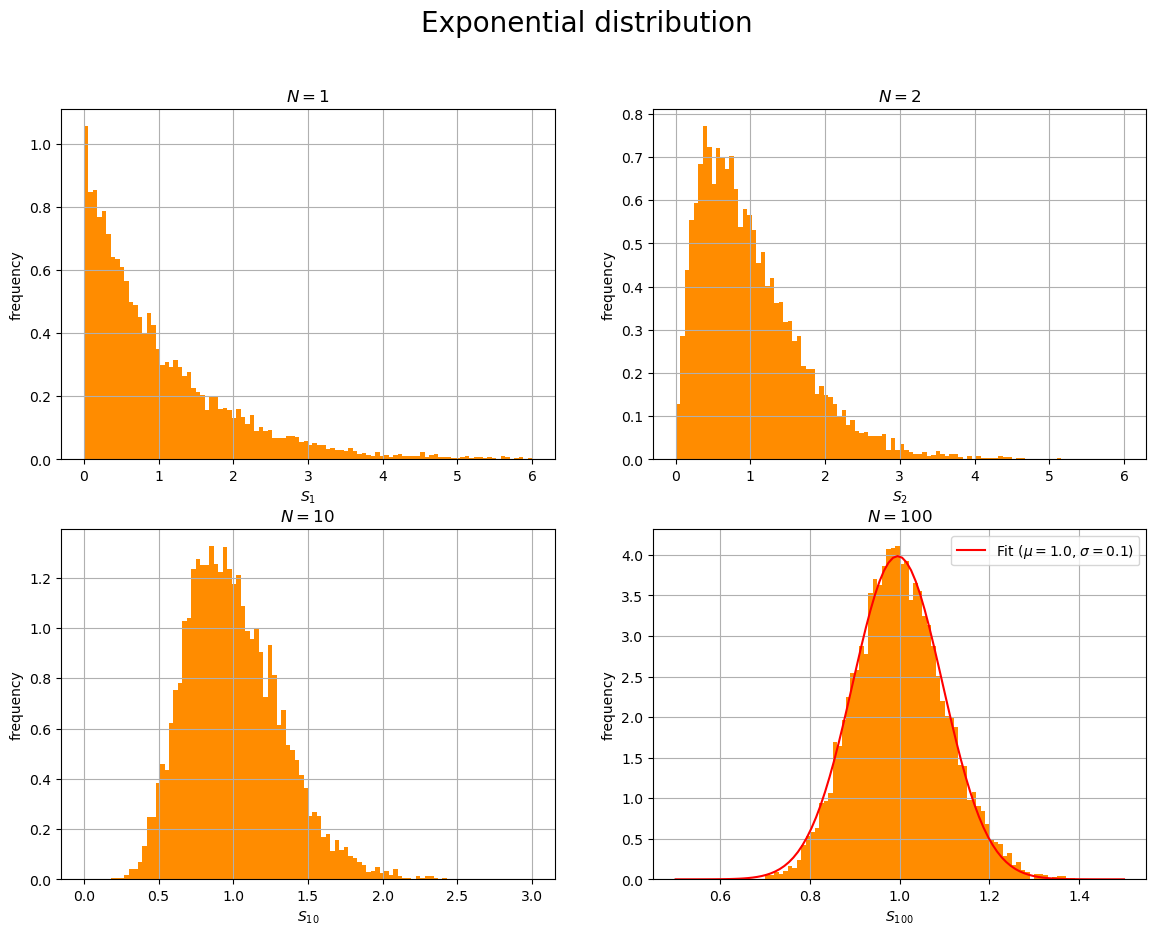

In [8]:
# Exponential distribution

# Data acquisition
S_n1, S_n2, S_n3, S_n4= np.loadtxt("./1.2/1.2_exponential.dat", unpack = True, usecols=(1,2,3,4))

#style
fig=plt.figure(figsize = (14,10))
fig.suptitle('Exponential distribution', fontsize=20)

#plot
plt.subplot(2,2,1)
n, bins, patches = plt.hist(S_n1, n_bins, range = (0,6), density = True, color = 'darkorange')
plt.grid()
plt.ylabel("frequency")
plt.title("$N=1$")
plt.xlabel("$S_1$")


plt.subplot(2,2,2)
n, bins, patches = plt.hist(S_n2, n_bins, range = (0,6), density = True, color = 'darkorange')
plt.grid()
plt.ylabel("frequency")
plt.title("$N=2$")
plt.xlabel("$S_2$")


plt.subplot(2,2,3)
n, bins, patches = plt.hist(S_n3, n_bins, range = (0,3), density = True, color = 'darkorange')
plt.grid()
plt.ylabel("frequency")
plt.xlabel("$S_{10}$")
plt.title("$N=10$")

plt.subplot(2,2,4)
n, bins, patches = plt.hist(S_n4, n_bins, range = (0.5,1.5), density = True, color = 'darkorange')
plt.grid()
plt.ylabel("frequency")
plt.xlabel("$S_{100}$")
plt.title("$N=100$")


#fit
bins = np.linspace(0.5, 1.5, 10001)
data_entries, bins = np.histogram(S_n4, bins = bins, density = True)
binscenters = np.array([0.5 * (bins[i] + bins[i + 1]) for i in range(len(bins)-1)])
popt, pcov = curve_fit(gauss, xdata = binscenters, ydata = data_entries)
xspace = np.linspace(0.5, 1.5, 100)
y_fit = gauss(xspace, popt[0], popt[1])

#plot fit
lab ='Fit ($\mu=$' + str(round(popt[0], 2)) + ', $\sigma=$' + str(round(popt[1], 2)) + ')'
plt.plot(xspace, y_fit, color = 'red', label = lab)
plt.legend()

plt.show()

### Cauchy-Lorentz distribution

The Cauchy-Loretnz distribution is a bit more challenging:
$$p(x)=\frac{1}{\pi}\frac{\Gamma}{(x-\mu)^2+\Gamma^2}$$
Its cumulative distribution
$$ F(x) = \int^x_{-\infty} p(x) = \frac{1}{\pi}\arctan\left(\frac{x-\mu}{\Gamma}\right)+\frac{1}{2} $$
which when inverted yields to the transformation:
$$x = \mu + \Gamma\cdot\tan\left[\pi\left(F(x)-\frac{1}{2}\right)\right]$$
Once I have the transformations, I simply perform the simulations as requested, once again showing below the histograms for $10^5$ iterations of the average $S_N = \frac{1}{N}\sum_{i=1}^N x_i$ for $N=1, 2, 10, 100$ and where $x_i$ are numbers drawn.

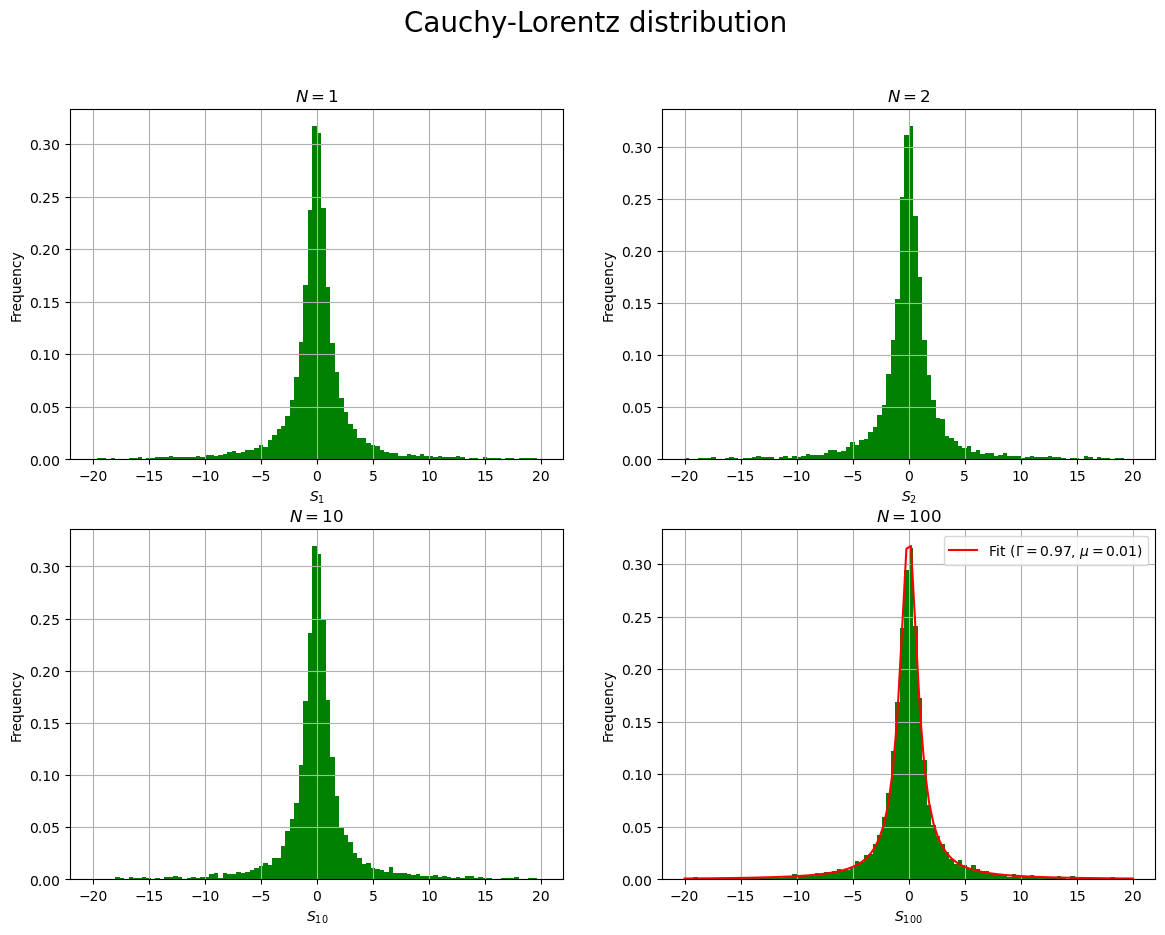

In [9]:
# Cauchy-Lorentz distribution

# defining the fitting function
def lorentz(x, gamma, x0):
    return cauchy.pdf(x, x0, gamma)

# Data acquisition
S_n1, S_n2, S_n3, S_n4= np.loadtxt("./1.2/1.2_lorentzian.dat", unpack = True, usecols=(1,2,3,4))

#style
fig=plt.figure(figsize = (14,10))
fig.suptitle('Cauchy-Lorentz distribution', fontsize=20)

#plot
plt.subplot(2,2,1)
n, bins, patches = plt.hist(S_n1, n_bins, range = (-20, 20), density = True, color = 'green')
plt.grid()
plt.ylabel("Frequency")
plt.xlabel("$S_1$")
plt.title("$N=1$")

plt.subplot(2,2,2)
n, bins, patches = plt.hist(S_n2, n_bins, range = (-20, 20), density = True, color = 'green')
plt.grid()
plt.ylabel("Frequency")
plt.xlabel("$S_2$")
plt.title("$N=2$")

plt.subplot(2,2,3)
n, bins, patches = plt.hist(S_n3, n_bins, range = (-20, 20), density = True, color = 'green')
plt.grid()
plt.ylabel("Frequency")
plt.xlabel("$S_{10}$")
plt.title("$N=10$")

plt.subplot(2,2,4)
n, bins, patches = plt.hist(S_n4, n_bins, range = (-20, 20), density = True, color = 'green')
plt.grid()
plt.ylabel("Frequency")
plt.xlabel("$S_{100}$")
plt.title("$N=100$")

#fit
bins = np.linspace(-10,10, 10001)
data_entries, bins = np.histogram(S_n4, bins = bins, density = True)
binscenters = np.array([0.5 * (bins[i] + bins[i+1]) for i in range(len(bins)-1)])
popt, pcov = curve_fit(lorentz, xdata = binscenters, ydata = data_entries)
xspace = np.linspace(-20,20,100)
y_fit = lorentz(xspace, *popt)

#plot
lab = 'Fit ($\Gamma=$' + str(round(popt[0],2)) + ', $\mu=$' + str(round(popt[1],2)) + ')'
plt.plot(xspace, y_fit, color = 'red',  label = lab)
plt.legend()

plt.show()

Here the fit was done differently. In fact as above mentioned and as can be easily observed through these 4 histograms which vary almost not at all, the Cauchy-Lorentz distribution is very stable, and thus the fit was performed using the fit function `cauchy` imported from the `scipy.stats` library. The result of the fit gives parameters comparable to those provided to the code at the beginning of the sampling, i.e. $\Gamma = 1$ and $\mu = 0$.

## 1.3

**Simulate** the Buffon’s experiment (see LSN_Lecture_00, supplementary material):  A needle of length $N$ is thrown at random onto a horizontal plane ruled with straight lines a distance $d$ (must be $d > N$, but do not use $d\gg N$ otherwise $P\ll 1$) apart. The probability $P$ that the needle will intersect one of these lines is: $P = 2L/\pi d$. This could be used to evaluate $\pi$ from throws of the needle: if the needle is thrown down $N_{thr}$ times and is observed to land on a line $N_{hit}$ of those times, we can make an estimate of $\pi$ from
$$\pi = \frac{2L}{Pd} = \lim_{N_{thr} \to \infty}\frac{2LN_{thr}}{N_{hit}d}$$
Make a picture of the estimation of $\pi$ and its uncertainty (Standard Deviation of the mean) with a large number of *throws* $M$ as a function of the number of blocks, $N$ (see below: Computing statistical uncertainties). If possible, do not use $\pi$ to evaluate $\pi$.

## Solution

To simulate the Buffon's experiment, the Random Number Generator had to be utilized to draw a random throw of the needle onto the horizontal ruled plane and be able to decide whether or not that throw had hit one of the lines. This is how I decided to implement this exercise.

The constants of the problem were defined at the beginning, needle length $L=0.5$ and distance between the lines $d=2.0$. For the block averaging, we took `blocks` $=100$ and `iterations` $= 10^6$ for a `blockSize` $= 10000$.
<br>The first step was to draw a position of one of the ends of the needle, and thanks to the simmetry of the problem along the axis perpendicular to the lines, which made each slot between two lines the same as the next one, I was able to draw the first position in $(0,d)$ and save it in the variable `end1`. 
<br>Now to draw the placement of the needle on the grid, taking the lines to be drawn horizontally, I needed to draw the angle with the horizontal direction at which the needle fell. With an angle of $0$ being an horizontal throw, I had to draw in $(-\pi/2,\pi/2)$. However since we were estimating $\pi$, a good practice would be to not use the value of $\pi$ in the simulation. Here I noticed that we would only need the vertical projection of the angle, i.e. its $sin$ to see how far up of down the second end of the needle was drawn from the first. Thus I drew two numbers, $x$ uniformly in $(0,1)$ and $y$ uniformly in $(-1,1)$. Now, after checking that they describe a position within the unit circle, i.e. $\sqrt{x^2+y^2} < 1 $, I could evaluate 
$$ \sin \theta = \frac{y}{\sqrt{x^2+y^2}} $$
and have this be the vertical length of my needle throw. 
<br>And finally I could evaluate whether the throw had hit a line: the position of the second end of the needle could be found with
````cpp
double end2 = end1 + L * sin_theta
````
Now if `end2` was not between $0$ and $d$, the needle had intersected a line, either the line at position $d$ or the one at $0$. Thus the counter `Nhits` was incremented.
<br>Finally after each block, the evaluation of $\pi$ was done with the formula
$$\pi = \frac{2L}{Pd} = \frac{2LN_{thr}}{N_{hit}d}$$
with $N_{hit}=$`Nhits` and $N_{thr}=$`blockSize`. Finally the output file `1.3.dat` was filled with the block averaging data.

The described code can be found in the `main.cpp` inside the directory `./1.3`. 

Below we show the output values of block averaging in fuction of the number of blocks, and also a graph of progressive error.

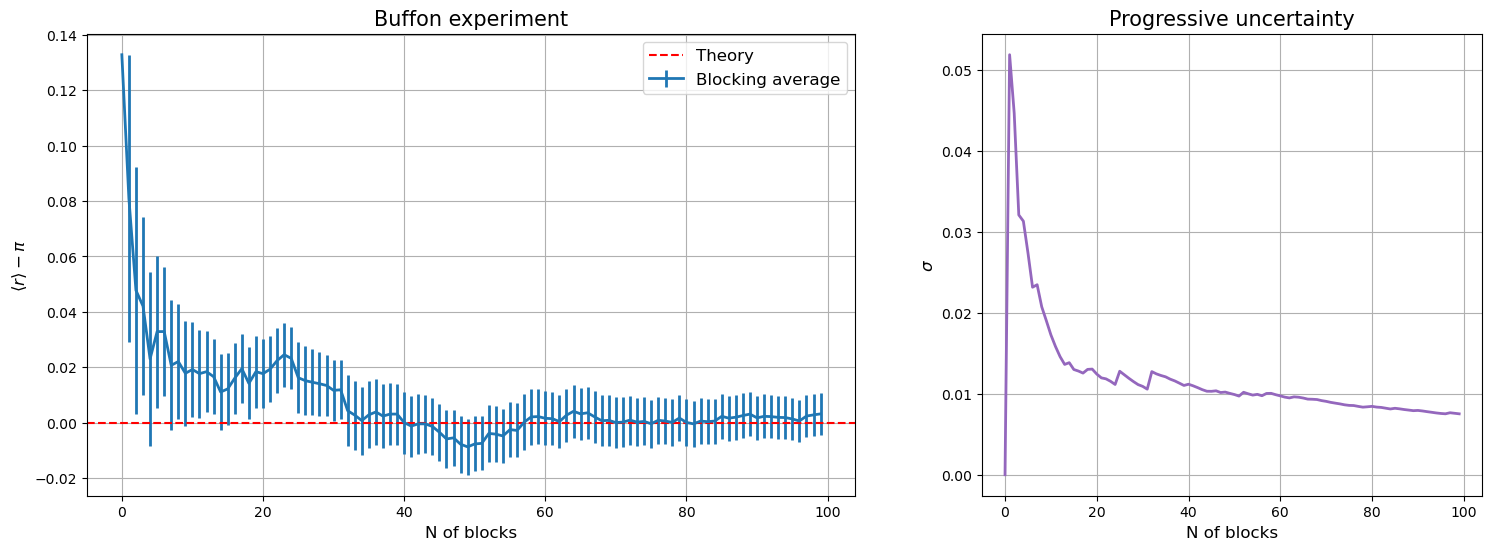

In [10]:
# Load data from file './1.3/1.3.dat', using columns 0 and 1
x_label, progressive_average, progressive_error = np.loadtxt('./1.3/1.3.dat', unpack = True, usecols=(0, 1, 2))

# Create a figure with 2 subplots, using width ratios of [2, 1.3] for the subplots
fig, axs = plt.subplots(ncols=2, gridspec_kw={'width_ratios': [2, 1.3]}, figsize=(18,6))

# Plot data in the first subplot
axs[0].errorbar(x_label, progressive_average - np.pi, yerr=progressive_error,lw=2, label='Blocking average', c='tab:blue')
axs[0].grid(True)  # Add grid lines to the plot
axs[0].axhline(0, ls='--', c='red', label='Theory')  # Add a horizontal line at y=0 in red
axs[0].set_xlabel('N of blocks', fontsize=12)
axs[0].set_ylabel(r'$\left\langle r \right\rangle - \pi $', fontsize=12)
axs[0].legend(fontsize=12)  # Add a legend to the plot
axs[0].set_title('Buffon experiment', fontsize=15)

# Plot data in the second subplot
axs[1].plot(x_label, progressive_error,lw=2, c='tab:purple')
axs[1].grid(True)  # Add grid lines to the plot
axs[1].set_xlabel('N of blocks', fontsize=12)
axs[1].set_ylabel('$\sigma$', fontsize=12)
axs[1].set_title('Progressive uncertainty', fontsize=15)


# Show the plot
plt.show()

The estimation of $\pi$ from the graph can be seen quickly converging and settling pretty close to the actual value of $\pi$ with a final error of less than $0.01$.